In [3]:
import scipy.io
import os.path
import matplotlib.pyplot as plt
import numpy as np
import statistics
from scipy import signal

C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
!cd

D:\jupyter default folder


In [5]:
os.path.isfile('D:/jupyter default folder/Clustering_input_processing/AllDFLStepData.mat')

True

In [6]:
data = scipy.io.loadmat('D:/jupyter default folder/Clustering_input_processing/AllDFLStepData.mat')

## 1. Data structure & Objective

### A）Import mat file into notebook
data is a dict, keys are dict_keys(['__header__', '__version__', '__globals__', 'AllDFLStepData'])

In [7]:
#overall mat object is a dictf
print(type(data))
print(data.keys())

<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'AllDFLStepData'])


### B）data['AllDFLStepData'][0] Structure summary
- subject 0
    - Calibration (with feedback) - 2 sessions
        - sr: sampleing rate? 500hz
        - CueLabels: 110-111-112 >> l-m-r - 30 cues(one cue/recording)
        - DFLData - 30 recording, one recording 6s
            - EMG (our target) - 4channel*3001 points >> 
            - etc...
    - VR experiment (without feedback) - 3 sessions
        - sr: sampleing rate? 500hz
        - CueLabels: 110-111-112 >> l-m-r - 30 cues(one cue/recording)
        - DFLData - 30 recording, one recording 6s
            - EMG (our target) - 4channel*3001 points >> 
            - etc...
- subject 2
- subject 3
- subject 4
#### Under subject - calib/VR >> 5种field 
                       sr: 500
                CueLabels: [110 112 111 112 111 110 110 112 112 110 111 111 110 111 110 112 112 112 110 112 111 111 110 112 111 112 110 111 111 110]
                   CuePos: [4491 11998 19645 28388 36930 44585 52135 60024 68211 76068 83967 92705 100811 109061 116699 125221 132929 140587 148222 156828 165060 173374 181195 189597 197338 205279 212819 220400 228356 235910]
    Idx_XEMG_LLegChannels: [1 2 3 4]
            IdxCueInRange: 1501
                  DFLData: [1×30 struct]
CueLabels means instruction given to subject.

### C) 2 types of section indexing example
#### - Calib 2 trails:
    [matfile 0:1]>> [one object 0:1] >> [1st subject 0:5 ] >> [calibrtion data] >> [one calib object 0:1] >> [1st data calib 0:2] >> [5 fields str key] >> [one CueLabels subject 0:1] >> [DFLData data  30 段recording 1:30] >> [15 data field 1:15]
#### - VR Exp 3 trails:
    [matfile 0:1]>> [one object 0:1] >> [1st subject 0:5 ] >> [exp data] >> [one calib object 0:1] >> [1st data calib 0:3] >> [5 fields str key] >> [one VR Exp subject 0:1] >> [DFLData data  30 段recording 1:30] >> [15 data field 1:15]

### D) Our objective: 
Using clustering techniche to check LeftLeg-EMG pre-cue signal whether can be clustered by a particular features with clear distinction
#### Note
 - First 1500 samples out of 3001 are the pre-cue samples, sampling rate 500sps
 - our target signal of ith recording for example is DFLData[i]

In [9]:
class AllDFLStepData(object):
    def __init__(self,raw_data):
        self.signal_map = {'EMG':1,
                     'MOT':0,
                     'EMG_RL':2}

        self.raw_data = raw_data

    def select_EMG_data(self,subject_no,session,section_no, total_records,signal_type,channel):
        #subject_no [0:5] -> 5 subjects
        #session 'DFLStepDataSet_VR'/ 'DFLStepDataSet_Calib'
        #section_no VR:3/Calib:2
        signal_index = self.signal_map[signal_type]
        VRdata_section = [[0 for j in range(channel)] for i in range(total_records)] 
        for i in range(total_records): #recording number
            for j in range(channel): # channel
                #print(i,j,subject_no,session,section_no, total_records,signal_type)
                VRdata_section[i][j] = self.raw_data['AllDFLStepData'][0][subject_no][session][0][section_no]['DFLData'][0][i][signal_index][j]
        return VRdata_section
    
    def select_EMG_label(self,subject_no,session,section_no):
        #print(i,j,subject_no,session,section_no, total_records,signal_type)
        Label = self.raw_data['AllDFLStepData'][0][subject_no][session][0][section_no]['CueLabels']
        return Label
        
    
    def EMG_filter(self,subject_no,session,section_no, total_records,signal_type,channel):
        signal_index = self.signal_map[signal_type]
        filtered_EMG = [[0 for j in range(channel)] for i in range(total_records)]
        for i in range(total_records): #recording number
            for j in range(channel): # channel
                #print(i,j,subject_no,session,section_no, total_records,signal_type)
                filtered_EMG[i][j] = butterworth_bandp(self.raw_data['AllDFLStepData'][0][subject_no][session][0][section_no]['DFLData'][0][i][signal_index][j],50,150)
        return filtered_EMG    
    
    def plot_EMG(data,data_range,channel):
        print('EMG signal waveforms in the range of {}'.format(data_range))
        fig,ax = plt.subplots(len(data_range),channel,figsize=(14, 0.5*len(data_range)))
        for i,record_no in enumerate(data_range):
            for j in range(channel):
                if ax.shape == (1,1):
                    ax[j].plot(data[record_no][j])
                    ax[j].set_title('Recording '+str(record_no)+'  channel '+str(j+1))
                else:
                    ax[i,j].plot(data[record_no][j])
                    ax[i,j].set_title('Recording '+str(record_no)+'  channel '+str(j+1))
                plt.subplots_adjust(hspace=1)
        plt.show()
        
Alldata = AllDFLStepData(data)

## 2. Data Pre-processing & Feature extraction

### A) Abnormal recording
Manual pick recording with abnormal waveform.
#### i. Error type
0: 线性变化

1: no pulse, constant value >> -185000

#### ii. Error summary

*All error is at channel 1 of subject 0.*

Calib subject 3,4,5 low frequency noise is very high.

VR 29 recordings, Calib 30 recordings

VR sub 0, record 10, channel 3 a lot of noise; sub 1 noisy; sub 3 noisy;sub 4 noisy

#### iii. *Array for Abnormal recording [format: *subject_no (), session_no(), recording_no(), channel_no(), type of error*]

Error_Calib = [[0,0,0:30,1,0],
               [0,1,0:15,1,1],[0,1,16:18,1,1],[0,1,16:18,1,1],[0,1,19:20,1,1],[0,1,21:26,1,1],[0,1,27:28,1,0],[0,1,29,1,1],
              ]
              
Error_VR = [[0,0,0:29,1,1],
            [0,1,0,1,0],[0,1,1:29,1,1],
            [0,2,0:29,1,1]]

### B) Pre-processing

#### i. Filter - Butterworth

In [33]:
def butterworth_bandp(sig,low,high,fs=500,order = 5):
    b, a = scipy.signal.butter(order, [low/fs*2,high/fs*2], 'band')
    output_signal = scipy.signal.filtfilt(b, a, sig)
    return output_signal

def butterworth_lowp(sig,low,fs=500,order = 5):
    b, a = scipy.signal.butter(order, low/fs*2, 'band')
    output_signal = scipy.signal.filtfilt(b, a, sig)
    return output_signal

#plot filtered data
def plot_processed_data(filtered_EMG,labels,channel=4,fs = 500,time = 6,samples = 3001):
    t = np.linspace(0,time,samples)
    total_records = len(filtered_EMG)
    '''
    total_records = min(filtered_EMG.shape[0],29)
    if filtered_EMG.shape[0] >=30:
        print('total length is'+str( filtered_EMG.shape[0]))
        print('First 29 records are shown')
    '''    
    rows = total_records
    cols = channel
    fig = plt.figure(figsize=(15,total_records*2), constrained_layout=True) #note here, constrained_layout means sliding
    fig.suptitle('LeftLegEMG Waveform')
    # create rows x 1 subfigs
    subfigs = fig.subfigures(nrows=rows, ncols=1)
   
    for i, subfig in enumerate(subfigs):
        subfig.suptitle(labels[0][i])
        # create 1 x cols subplots per subfig
        axs = subfig.subplots(nrows=1, ncols=cols)
        for j, ax in enumerate(axs):
            ax.plot(t,filtered_EMG[i][j])
            ax.set_title('Recording '+str(i)+'  channel '+str(j+1))
    plt.show()

### C) Feature Extraction

#### i. Energy

In [11]:
def EMG_energy(emg,fs):
    total_records = len(emg)
    channel = len(emg[0])
    Sr = [[0 for j in range(channel)] for i in range(total_records)]
    fr =  [[0 for j in range(channel)] for i in range(total_records)]
    for i in range(total_records): #recording number
        for j in range(channel): # channel
            Sr[i][j] = signal.welch(emg[i][j], fs)[0] #return Sr
            fr[i][j] = signal.welch(emg[i][j], fs)[1] #return fr)
    return Sr,fr

#plot energy data!!!!
def plot_energy_data(Sr,fr):
    total_records = len(fr)
    channel = len(fr[0])
    fig,ax = plt.subplots(total_records,channel,figsize = (14,total_records*0.5))
    for i in range(total_records):
        for j in range(channel):
            if ax.shape == (1,1):
                ax[j].plot(Sr[i][j],fr[i][j])
                ax[j].set_title('Recording '+str(i)+'  channel '+str(j+1))
            else:
                ax[i,j].plot(Sr[i][j],fr[i][j])
                ax[i,j].set_title('Recording '+str(i)+'  channel '+str(j+1))
            plt.subplots_adjust(hspace=1)
    plt.show()

#### ii. Root Mean Square (RMS)

In [12]:
from sklearn.preprocessing import normalize
def rms(emg,window):
    total_records = len(emg)
    channel = len(emg[0])
    siglen = len(emg[0][0]) #3001
    #result matrics >> records x channel x sub-group
    EMG_RMS = [[[0 for k in range(siglen//window)] for j in range(channel)] for i in range(total_records)]
    for i in range(total_records): #recording number
        for j in range(channel): # channel
            for k in range(0,siglen//window): #rms of a window
                EMG_RMS[i][j][k] = np.sqrt(np.mean(emg[i][j][k*window:(k+1)*window]**2))
    return EMG_RMS/np.linalg.norm(EMG_RMS)
#https://stackoverflow.com/questions/21030391/how-to-normalize-a-numpy-array-to-a-unit-vector

## 3. Pattern Exploration

### A) Pre-cue EMG clustering - use sub 1, session 0 as an example! trail first

#### i. Normalised RMS + PCA + K-Means
https://stackoverflow.com/questions/34972142/sklearn-logistic-regression-valueerror-found-array-with-dim-3-estimator-expec
https://stackoverflow.com/questions/48003185/sklearn-dimensionality-issues-found-array-with-dim-3-estimator-expected-2

PCA: https://stackoverflow.com/questions/34972142/sklearn-logistic-regression-valueerror-found-array-with-dim-3-estimator-expec

In [13]:
d2_pre_cue_rms_Calibfrom sklearn.cluster import KMeans

#### ia)1 subject - section 0 - 29 recording Clustering

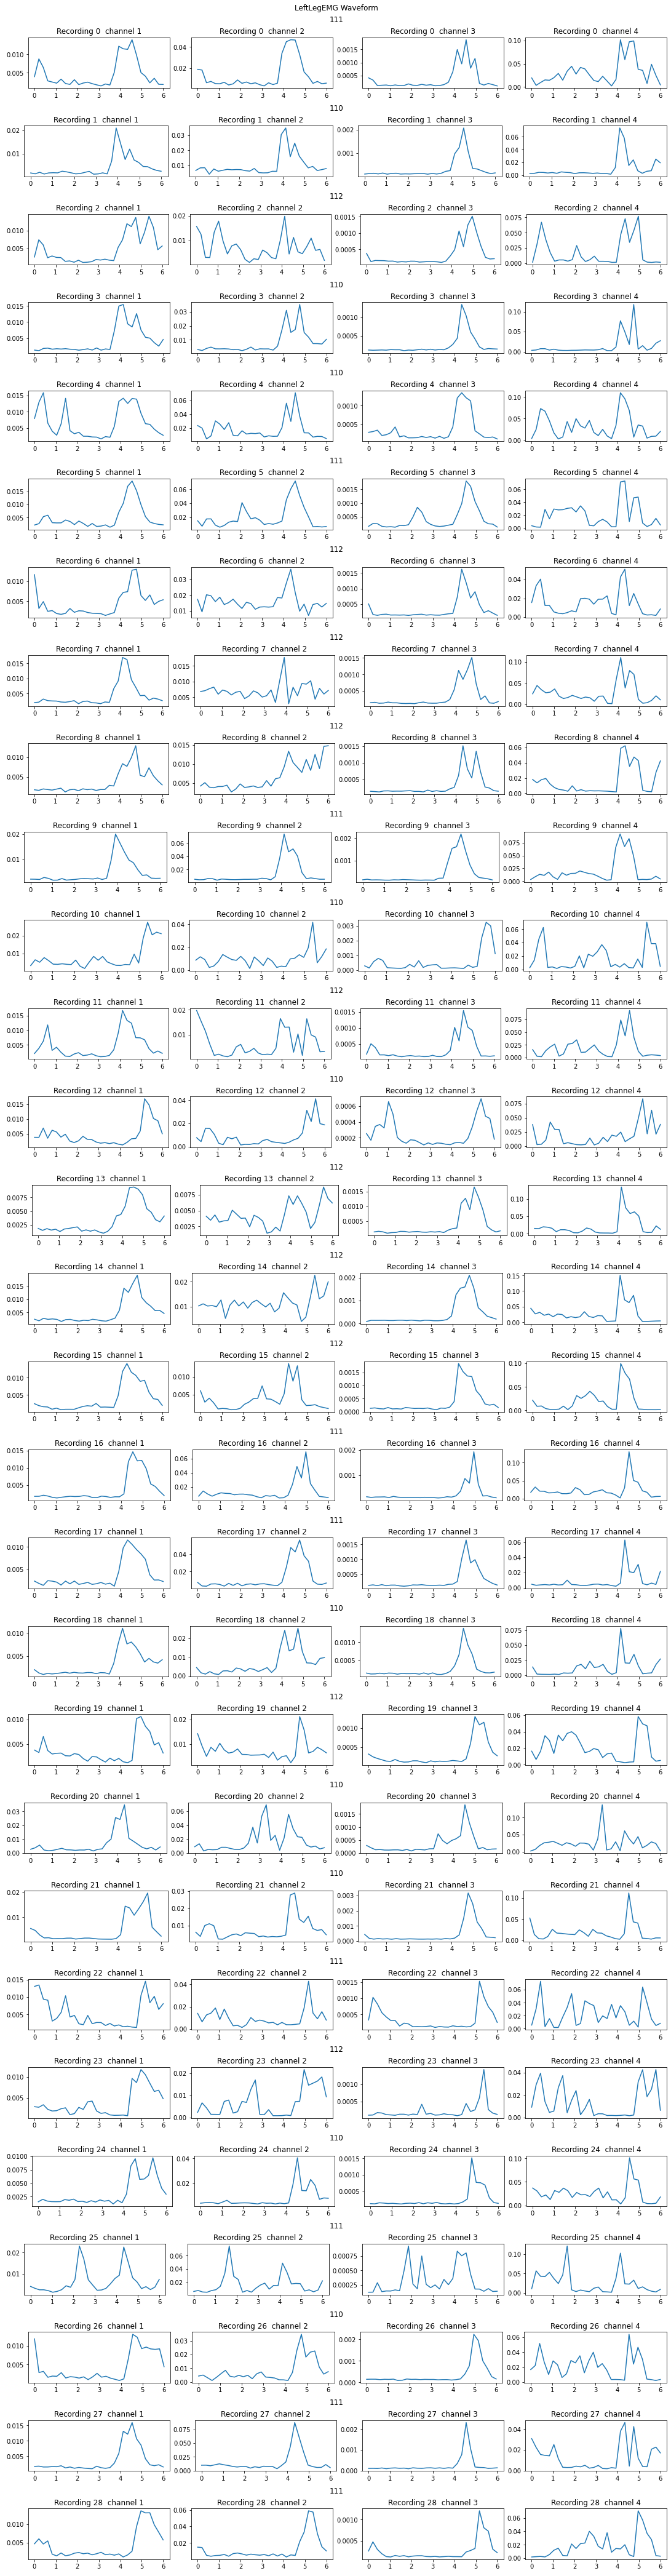

In [15]:
#single subject, rms feature clustering
filtered_EMG_VR00 = Alldata.EMG_filter(1,'DFLStepDataSet_VR',section_no = 0, total_records = 29,signal_type = 'EMG',channel=4)
labels = Alldata.select_EMG_label(1,'DFLStepDataSet_VR',section_no = 0)
Sr,fr = EMG_energy(filtered_EMG_VR00,500)
emg_rms = rms(filtered_EMG_VR00,window = 100)
pre_cue_rms = emg_rms[:,:,0:15]
plot_processed_data(emg_rms,labels,time = 6,samples = 3001//100)

#### Experiment on different choice of Parameters

n_components = 20, cluster = 4

(29, 60)
(29, 2)


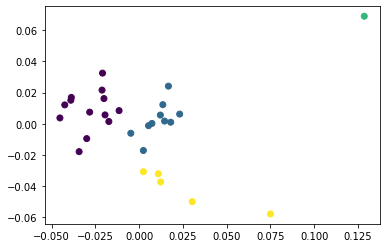

[1 0 3 0 3 1 1 1 0 0 3 0 0 0 1 0 1 0 0 1 1 0 3 1 1 2 3 0 0]


In [36]:
#pca
nsamples = 29
nx = 4
ny = 15
d2_pre_cue_rms = pre_cue_rms.reshape((nsamples,nx*ny)) #reshape into 2d array
print(d2_pre_cue_rms.shape)
pca = PCA(n_components=2)
pca.fit(d2_pre_cue_rms)
input_rms = pca.transform(d2_pre_cue_rms)
print(input_rms.shape)

#kmeans
y_pred = KMeans(n_clusters=4, random_state=9).fit_predict(input_rms)
plt.scatter(input_rms[:, 0], input_rms[:, 1], c=y_pred)
plt.show()
print(y_pred)

n_components = 5, cluster = 4

(29, 5)


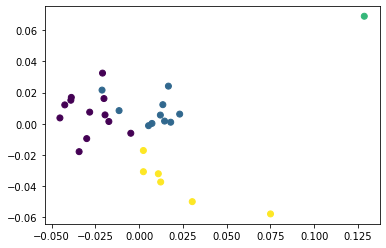

In [17]:
#pca
nsamples = 29
nx = 4
ny = 15
d2_pre_cue_rms = pre_cue_rms.reshape((nsamples,nx*ny)) #reshape into 2d array
pca = PCA(n_components=5)
pca.fit(d2_pre_cue_rms)
input_rms = pca.transform(d2_pre_cue_rms)
print(input_rms.shape)

#kmeans
y_pred = KMeans(n_clusters=4, random_state=9).fit_predict(input_rms)
plt.scatter(input_rms[:, 0], input_rms[:, 1], c=y_pred)
plt.show()

No PCA, cluster = 4

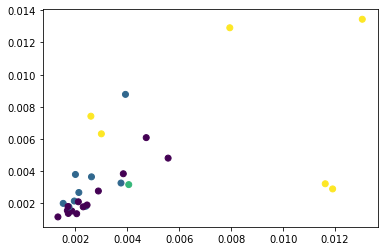

[1 0 3 0 3 1 3 1 0 0 3 1 0 0 1 0 1 0 0 1 1 1 3 0 1 2 3 0 0]


In [18]:
nsamples = 29
nx = 4
ny = 15
#faltten into 2d array.
d2_pre_cue_rms = pre_cue_rms.reshape((nsamples,nx*ny)) #reshape into 2d array

y_pred2 = KMeans(n_clusters=4, random_state=9).fit_predict(d2_pre_cue_rmsn_components = 20, cluster = 4)
plt.scatter(d2_pre_cue_rms[:, 0], d2_pre_cue_rms[:, 1], c=y_pred2)
plt.show()
print(y_pred)

#### 1b) All subjects & section for VR/Calib

In [19]:
#selec all data in this session, then filtered + extract features on it.
def EMG_filtered_rms_all(session = 'DFLStepDataSet_VR'):
    section = 3 if session == 'DFLStepDataSet_VR' else 2
    records = 29 if session == 'DFLStepDataSet_VR' else 30
    filtered_EMG_VR = np.array([0])
    for i in range(5): # 5 subject
        for j in range(section): # 2/3 sessions
            temp_filtered = Alldata.EMG_filter(i,session,section_no = j, total_records = records,signal_type = 'EMG',channel=4)
            temp = rms(temp_filtered ,window = 100)
            temp = np.vstack((temp,temp))
        filtered_EMG_VR = np.vstack((filtered_EMG_VR,temp)) if filtered_EMG_VR.all() != False else temp
    return filtered_EMG_VR

def label_all(session):
    section = 3 if session == 'DFLStepDataSet_VR' else 2
    records = 30 if session == 'DFLStepDataSet_Calib' else 29
    labels = np.array([0])
    for i in range(5): # 5 subject
        for j in range(section): # 2/3 sessions
            print(i,j)
            temp = Alldata.select_EMG_label(i,session,section_no = j)
            temp = np.vstack((temp,temp))
        labels = np.vstack((labels,temp)) if labels.all() != False else temp
    return labels

Select VR, Calib data seperatly (all subjects, all sessions)

In [20]:
#VR >>29
EMG_VR = EMG_filtered_rms_all('DFLStepDataSet_VR')
pre_cue_rms_VR = EMG_VR[:,:,0:15]
#labels_VR = label_all('DFLStepDataSet_VR')
#plot_processed_data(pre_cue_rms_VR,labels_VR,time = 3,samples = 15) #half()

In [21]:
EMG_Calib = EMG_filtered_rms_all('DFLStepDataSet_Calib')
pre_cue_rms_Calib = EMG_Calib[:,:,0:15]
#labels_Calib = label_all('DFLStepDataSet_Calib') 
#plot_processed_data(pre_cue_rms_Calib,labels_Calib,time = 3,samples = 15) #half

PCA n_compoents = 4

(300, 4)


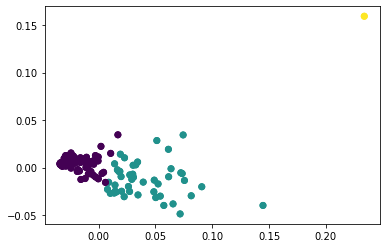

In [32]:
#Calib 
#pca
nsamples = 300
nx = 4
ny = 15
d2_pre_cue_rms_Calib = pre_cue_rms_Calib.reshape((nsamples,nx*ny))
pca = PCA(n_components=4)
pca.fit(d2_pre_cue_rms_Calib)
input_rms = pca.transform(d2_pre_cue_rms_Calib)
print(input_rms.shape)
#kmeans
y_pred = KMeans(n_clusters=3, random_state=9).fit_predict(input_rms)
plt.scatter(input_rms[:, 0], input_rms[:, 1], c=y_pred)
plt.show()

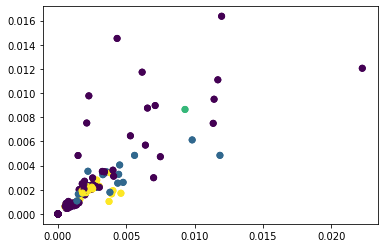

In [37]:
nsamples = 300
nx = 4
ny = 15
#faltten into 2d array.
d2_pre_cue_rms_Calib = pre_cue_rms_Calib.reshape((nsamples,nx*ny)) #reshape into 2d array

y_pred2 = KMeans(n_clusters=4, random_state=9).fit_predict(d2_pre_cue_rms_Calib)
plt.scatter(d2_pre_cue_rms_Calib[:, 1], d2_pre_cue_rms_Calib[:, 6], c=y_pred2)
plt.show()

In [23]:
pre_cue_rms_VR.shape

(290, 4, 15)

VR data

(290, 2)


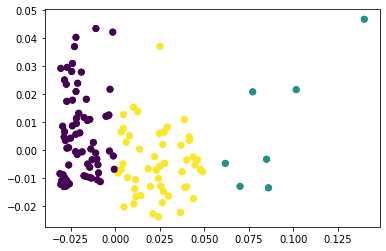

In [24]:
#VR 
#pca
nsamples = 290
nx = 4
ny = 15
d2_pre_cue_rms_VR = pre_cue_rms_VR.reshape((nsamples,nx*ny))
#
pca = PCA(n_components=2)
pca.fit(d2_pre_cue_rms_VR)
input_rms = pca.transform(d2_pre_cue_rms_VR)
print(input_rms.shape)
#kmeans
y_pred = KMeans(n_clusters=3, random_state=9).fit_predict(input_rms)
plt.scatter(input_rms[:, 0], input_rms[:, 1], c=y_pred)
plt.show()

No PCA

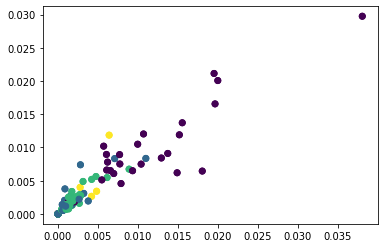

In [26]:
nsamples = 290
nx = 4
ny = 15
#faltten into 2d array.
d2_pre_cue_rms_VR = pre_cue_rms_VR.reshape((nsamples,nx*ny)) #reshape into 2d array

y_pred2 = KMeans(n_clusters=4, random_state=9).fit_predict(d2_pre_cue_rms_VR)
plt.scatter(d2_pre_cue_rms_VR[:, 0], d2_pre_cue_rms_VR[:, 1], c=y_pred2)
plt.show()

#### Next-step:
1. understand how PCA works, effect of n_components in this case. Does reshape into 2d array for PCA affects the result.
 - in this case, we flatten emg into 2d to fit PCA. Any other method won't destroy it's structure?
2. Interprate the current clustering
3. explore different combintion of features and dimesional reduction technique.
4. improve pre-processing algorithms
5. write a loop function to plot clustering results of different model/hyper-parameters

#### Tasks
1. pre-cue 2s: use a subject as a unit?